# Spam classifier



In [6]:
import os
import numpy as np
import pandas as pd

from utils import fetch_data, load_email, make_email_example, plot_precision_recall_vs_threshold

#from sklearn.model_selection import train_test_split
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
#from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve

import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from langdetect import DetectorFactory

from tqdm.notebook import tqdm

pd.set_option('max_colwidth', 100)
tqdm.pandas()

ModuleNotFoundError: No module named 'utils'

## Download email corpus

Download and extract some genuine emails and spams from the SpamAssassin public email corpus.

Source: https://spamassassin.apache.org/old/publiccorpus/

In [ ]:
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
SPAM_PATH = os.path.join("datasets", "spam")

fetch_data(DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_easy_ham_2.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_hard_ham.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_spam.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_spam_2.tar.bz2", SPAM_PATH)

## Import raw emails
Then we have used parsing.

In [3]:

easy_ham_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'easy_ham')) if name != 'cmds']
easy_ham_2_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'easy_ham_2')) if name != 'cmds']
hard_ham_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'hard_ham')) if name != 'cmds']
spam_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'spam')) if name != 'cmds']
spam_2_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'spam_2')) if name != 'cmds']

easy_ham_emails = [load_email(os.path.join(SPAM_PATH, 'easy_ham'), name) for name in easy_ham_filenames]
easy_ham_2_emails = [load_email(os.path.join(SPAM_PATH, 'easy_ham_2'), name) for name in easy_ham_2_filenames]
hard_ham_emails = [load_email(os.path.join(SPAM_PATH, 'hard_ham'), name) for name in hard_ham_filenames]
spam_emails = [load_email(os.path.join(SPAM_PATH, 'spam'), name) for name in spam_filenames]
spam_2_emails = [load_email(os.path.join(SPAM_PATH, 'spam_2'), name) for name in spam_2_filenames]


## Create labelled examples

#Scraping the text from the emails and add it to an 1x2 array with the label (1=spam, 0=no spam).

In [5]:
%%time

examples = np.empty((0,2), 'object')
for i, he in enumerate(easy_ham_emails + easy_ham_2_emails + hard_ham_emails):
    try:
        examples = np.append(examples, make_email_example(he, is_spam=False, clean=True), axis=0)
    except:
        print(i)
for i, se in enumerate(spam_emails + spam_2_emails):
    try:
        examples = np.append(examples, make_email_example(se, is_spam=True, clean=True), axis=0)
    except:
        print(i)

df = pd.DataFrame(examples, columns = ['Text', 'Spam'])
df.head()

NameError: name 'easy_ham_emails' is not defined

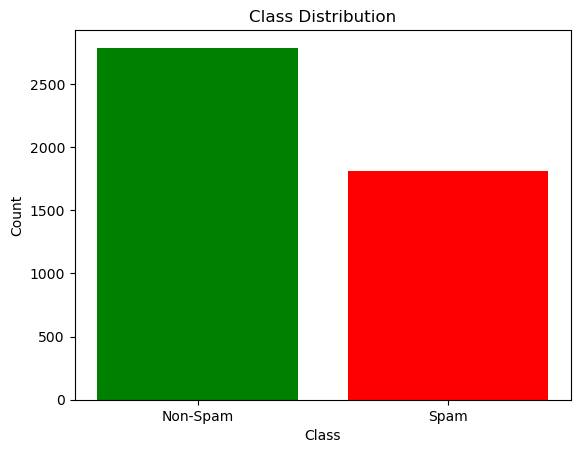

In [3]:
import matplotlib.pyplot as plt
labels = ['Non-Spam', 'Spam']
sizes = [2788, 1813]

plt.bar(labels, sizes, color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (48,) and arg 1 with shape (57,).

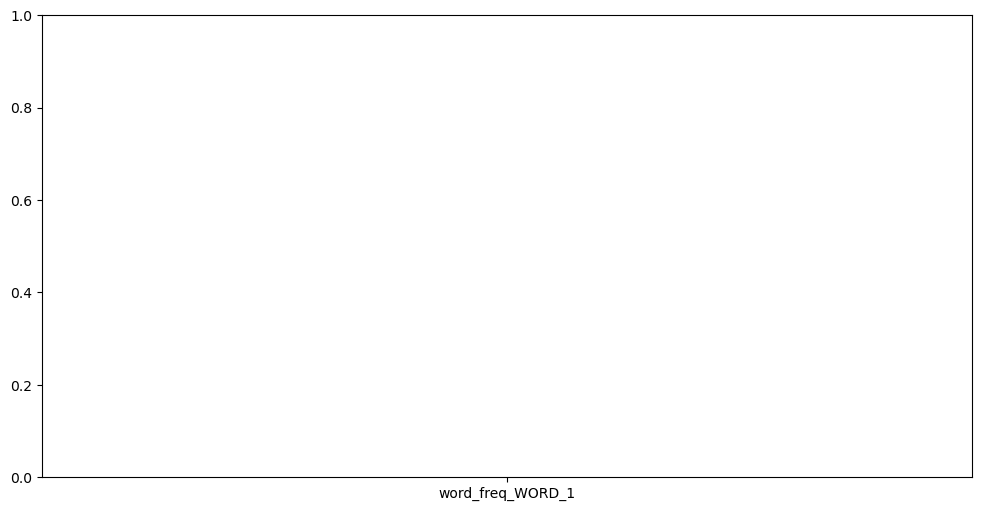

In [4]:
word_attributes_mean = [0.10455, 0.21301, 0.28066, 0.065425, 0.31222, 0.095901, 0.11421, 0.10529, 0.090067, 0.23941, 0.059824, 0.5417, 0.09393, 0.058626, 0.049205, 0.24885, 0.14259, 0.18474, 1.6621, 0.085577, 0.80976, 0.1212, 0.10165, 0.094269, 0.5495, 0.26538, 0.7673, 0.12484, 0.098915, 0.10285, 0.064753, 0.047048, 0.097229, 0.047835, 0.10541, 0.097477, 0.13695, 0.013201, 0.078629, 0.064834, 0.043667, 0.13234, 0.046099, 0.079196, 0.30122, 0.17982, 0.0054445, 0.031869, 0.038575, 0.13903, 0.016976, 0.26907, 0.075811, 0.044238, 5.1915, 52.173, 283.29]
attributes = [f'word_freq_WORD_{i+1}' for i in range(48)]

plt.figure(figsize=(12, 6))
plt.bar(attributes, word_attributes_mean, color='blue')
plt.title('Mean Word Frequency Attributes')
plt.xlabel('Word Attributes')
plt.ylabel('Mean Percentage')
plt.xticks(rotation=45)
plt.show()

# Character Frequency Attributes Analysis
char_attributes_mean = [0.10455, 0.21301, 0.28066, 0.065425, 0.31222, 0.095901]
char_attributes = [f'char_freq_CHAR_{i+1}' for i in range(6)]

plt.figure(figsize=(8, 6))
plt.bar(char_attributes, char_attributes_mean, color='purple')
plt.title('Mean Character Frequency Attributes')
plt.xlabel('Character Attributes')
plt.ylabel('Mean Percentage')
plt.show()

# Capital Run-Length Attributes Analysis
capital_attributes = {
    'capital_run_length_average': 5.1915,
    'capital_run_length_longest': 52.173,
    'capital_run_length_total': 283.29
}

plt.figure(figsize=(10, 6))
sns.boxplot(x=list(capital_attributes.keys()), y=list(capital_attributes.values()), color='orange')
plt.title('Capital Run-Length Attributes')
plt.ylabel('Count')
plt.show()

## Text preprocessing

Lemmatize and detect langugage with confidence score, then remove non-English emails or English emails with confidence less than 0.99

In [5]:
# Since SpaCy 3.0 to add custom factory component to Spacy pipeline:
# 1. create function with arguments nlp and name that returns a factory
# 2. decorate function with @Language.factory('foo')
@Language.factory('language_detector')
def get_lang_detector(nlp, name):
    DetectorFactory.seed = 42
    return LanguageDetector()

In [27]:
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('parser', 'ner')
nlp.add_pipe('sentencizer')
nlp.add_pipe('language_detector')
print("Spacy pipeline:", " > ".join(nlp.pipe_names))

def email_nlp_preproc(text):
    doc = nlp(text)
    lem = " ".join([token.lemma_ for token in doc])
    lang, conf = doc._.language.values()
    return lem, lang, conf

Spacy pipeline: tok2vec > tagger > attribute_ruler > lemmatizer > sentencizer > language_detector


In [28]:
df[['Text_Lemm', 'Lang', 'Conf']]  = pd.DataFrame(
    df['Text'].progress_apply(email_nlp_preproc).tolist()
    )

  0%|          | 0/6047 [00:00<?, ?it/s]

In [35]:
s = df[df.Lang == 'en'][['Text_Lemm', 'Lang', 'Conf']].sort_values('Conf').sample(5).style
s.set_table_styles({
   ('Text_Lemm'): [{'selector': 'td', 'props': 'max-width: 800px; overflow: hidden; text-overflow: ellipsis; white-space: nowrap;'},
              {'selector': 'td:hover', 'props': 'overflow: visible; white-space: normal;'}]
}, overwrite=False)
print("Here's some examples.\nHover on the text to see the full content.")
s

Here's some examples.
Hover on the text to see the full content.


,Text_Lemm,Lang,Conf
1145,"unseen window versus sequence window I apologize for not catch up to the current code in so long . now that I have I be try to resolve "" breakage "" and difference . the unseen window seem to have be replace with the sequence window . while I appreciate the flexibility of the sequence window , the unseen window fill an important - to - I need : it be tiny and could be set to show on all desktop of a virtual window manager without take a lot of space . since my normal mode of operation involve two copy of exmh display on a 1024x768 vnc session , screen space be at a premium . as thing stand now , I have a sequence window that show a lot more information than I need to have handy and take up a lot more room than I can "" spare "" . I can see that I could like the new sequence window a lot for certain operation . but I would like a nice uncluttered , tiny window that _ only _ show I info on my unread mail . one possibility that occur to I would be a button or mouse click that "" shrink "" the sequence window to show only the sequence in the "" always show "" list . and of course a way to expand it back . hal exmh - worker mailing list",en,0.999998
1489,"re : phew ! matt kettler say : ok , first , the important stuff . happy birthday justin ( a lil late , but oh well ) cheer ! a 13 % miss ratio on the spam corpus at 5.0 seem awfully high , although that nice low fp percentage be quite nice , as be the narrow - in of average fp / fn score compare to 2.40 . as dan say it be a hard corpus , make hard without the spamtrap datum . also and this be an important point those measurement can not be directly compare , because I change the methodology . in 2.40 the score be evolve on the entire corpus , then evaluate use that corpus ; ie . there be no "" blind "" testing , and the score could overfit and still provide good statistic . in 2.42 , they be evaluate "" blind "" , on a totally unseen set of message , so those figure would be a lot more accurate for real - world use . j.",en,0.999998
823,"re : ebusiness webform : cluetrain have leave the station ... webform /can/ accept "" u.s . of a "" as a country . incredible , but true . web form can also accept /multiple/ or even /free - form/ telephone number ... be the people who use procrustean web form practice the same one who do not accept fax ? when I * really * need to get something do , instead of just idle surfing , I call or fax . faxing , like a web form , can be do 24x7 ; it allow I to give all the ( and only the ) pertinent info in a single place ; it also provide a self - journalle correspondence , which mean rollback be easy and replay be even easy . -dave sure , tile window be the good we have for a brief period of time , but they be completely useless except for some terminal base replacement application . I 've be run a tiled ( but somewhat overlap , yield a horizontal stack ) window manager lately . like fill in a web form , find edge and shuffle window may seem productive , but I find that have a window manager manage the window mean I can concentrate on what I want to do with their content . "" dumb question : x client behind a firewall ? "" back in my day , they do not have ssh . then again , back in my day , they do not have firewall . back in my day , when one change computer installation , email would be forward as a courtesy . now , we seem to have swing so far in the opposite direction that it make sense to ditch address every couple of year to shed spam .",en,0.999997
1656,"deployment I think one step towards deployment be create a re - usable tokenizer for mail message . the current codebase do not expose an easy - to - use or easy - to - customize tokenizer . the timtest module seem to contain an enormous body of practical knowledge about how to parse mail message , but the module be not design for re - use . I would like to see a module that can take a single message or a collection of message and tokenize each one . I would like to s

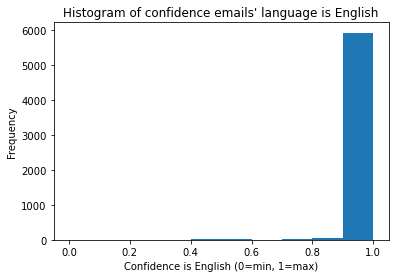

In [36]:
ax = df['Conf'].plot(kind='hist', title="Histogram of confidence emails' language is English")
_ = ax.set_xlabel("Confidence is English (0=min, 1=max)")

In [37]:
df_en = df[(df.Lang == 'en') & (df.Conf >= 0.99)]
print('Non-english emails removed:', len(df) - len(df_en))

Non-english emails removed: 181


## Training

Build the following pipeline and use it in a standard Grid Search CV to find the best hyperparameters the second and third stages of the pipeline.

**Pipeline:**
Lemmatizer > TF-IDF vectorizer > Naive Bayes classifier


In [38]:
X = df_en['Text_Lemm'].copy()
y = df_en['Spam'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
%%time

full_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB())
])

param_grid = [
    {
        'tfidf__stop_words': ['english'],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__max_df': [20, 50],
        'tfidf__min_df': [1, 10],
        'model__alpha': [.1, 1]
    }
]

kfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(full_pipeline, param_grid, cv=kfolds,
                           scoring=['accuracy', 'f1_weighted'], refit='accuracy', verbose=3)
                           
_ = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; accuracy: (test=0.930) f1_weighted: (test=0.928) total time=   2.5s
[CV 2/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; accuracy: (test=0.939) f1_weighted: (test=0.938) total time=   2.7s
[CV 3/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; accuracy: (test=0.932) f1_weighted: (test=0.930) total time=   2.5s
[CV 1/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__stop_words=english; accuracy: (test=0.974) f1_weighted: (test=0.974) total time=   5.6s
[CV 2/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__stop_words=english; accuracy: (test=0.974) f1_weighted: (test=0.974) total time=   5.9s

## Customize best model

Since this is a spam classifier it makes sense to maximize precision while worsening  recall.

In [40]:
y_proba = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=kfolds,
                            method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba[:, 1])

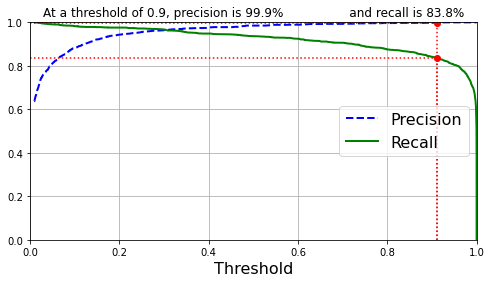

In [41]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=np.argmax(precisions >= .999))

## Test

Final metrics on unseen data.

In [42]:
custom_thr = thresholds[np.argmax(precisions >= .99)]
y_hat = grid_search.best_estimator_.predict_proba(X_test)[:,1] >= custom_thr

print(f"Accuracy: {accuracy_score(y_test, y_hat):.2%}")
print(f"Precision: {precision_score(y_test, y_hat):.2%}")
print(f"Recall: {recall_score(y_test, y_hat):.2%}")

Accuracy: 97.53%
Precision: 100.00%
Recall: 91.94%


## Making load data.py

In [2]:
import csv
import numpy as np
from numpy.random import RandomState
from sklearn.cross_validation import train_test_split

def load_data(Train=False):
    data = []

    # Read the training data
    f = open('data/spambase.data')
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        data.append(row)
    f.close()

    X = np.array([x[:-1] for x in data]).astype(np.float)
    y = np.array([x[-1] for x in data]).astype(np.float)
    del data # free up the memory

    if Train:
        # returns X_train, X_test, y_train, y_test
        return train_test_split(X, y, test_size=0.3, random_state=RandomState())
    else:
        return X, y

ModuleNotFoundError: No module named 'sklearn.cross_validation'

### Model Preparation

#### 1. Decision Trees


In [ ]:
from load_data import load_data
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import numpy as np
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO
from sklearn.metrics import roc_curve, auc
import pydot_ng
import operator


In [3]:
word_labels = ["make", "address", "all", "3d", "our", "over", "remove", "internet",
                "order", "mail", "receive", "will", "people", "report", "addresses",
                "free", "business", "email", "you", "credit", "your", "font", "000",
                "money", "hp", "hpl", "george", "650", "lab", "labs", "telnet", "857",
                "data", "415", "85", "technology", "1999", "parts", "pm", "direct", "cs",
                "meeting", "original", "project", "re", "edu", "table", "conference"]

iterations = 50
k = 5

def find_hyperparams(clf, X, y):
    # Set the parameters by cross-validation
    param_grid = [{'criterion': ['gini', 'entropy'],
                    'splitter': ['best', 'random'],
                    'max_features': ['sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ]}]
    grid = GridSearchCV(clf, param_grid)
    grid.fit(X, y)
    print('done fitting')
    return grid.best_estimator_

def top_k_features(k, weights):
    return sorted(zip(word_labels, weights), reverse=True, key=operator.itemgetter(1))[:k]

def show_auc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

scores = []
roc_auc = []

for i in range(iterations):
    X_train, X_test, y_train, y_test = load_data(Train=True)

    # For now, let's train only on word frequency vectors
    X_train = X_train[:, 0:48]
    X_test = X_test[:, 0:48]

    clf = DecisionTreeClassifier(criterion="entropy")
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc.append(auc(fpr, tpr))



#X, y = load_data()
#print(find_hyperparams(clf, X, y))

show_auc(y_test, clf.predict_proba(X_test)[:, 1])
print(top_k_features(5, clf.feature_importances_))

#dot_data = StringIO()
#export_graphviz(clf, out_file=dot_data, class_names=["Ham", "Spam"], feature_names=word_labels)
#graph = pydot_ng.graph_from_dot_data(dot_data.getvalue())
#graph.write_png("tree.png")

print('Accuracy. Avg: %0.5f, Std: %0.5f' % (np.mean(scores), np.std(scores)))
print('AUC. Avg: %0.5f, Std: %0.5f' % (np.mean(roc_auc), np.std(roc_auc)))

NameError: name 'load_data' is not defined

#### Naive Baiyes

In [4]:
import numpy as np
from scipy.misc import logsumexp

# Base class inspired by https://github.com/scikit-learn/scikit-learn/blob/a1860144aa2083277ba354b0cc46f9eb4acf0db0/sklearn/naive_bayes.py
class NaiveBayes:

    def fit(self, X, y):
        """Fit the Naive Bayes model to the input

        Arguments:
        X -- M x N numpy array
        y --  M x 1 numpy array, storing K unique labels

        Returns:
        None
        """

        raise NotImplementedError()

    def _predict_log_proba(self, X):
        """Predict the log of the label probabilities for the input

        Arguments:
        X -- M x N numpy array

        Returns:
        log_probabilities -- M x K numpy array
        """

        jll = self._joint_log_likelihood(X)
        log_prob = logsumexp(jll, axis=1)
        return jll - np.atleast_2d(log_prob).T

    def predict_proba(self, X):
        """Predict the label probabilities for the input

        Arguments:
        X -- M x N numpy array

        Returns:
        probabilities -- M x K numpy array
        """

        return np.exp(self._predict_log_proba(X))

    def predict(self, X):
        """Predict the labels for the input

        Arguments:
        X -- M x N numpy array

        Returns:
        probabilities -- M x K numpy array
        """

        return self._classes[np.argmax(self._joint_log_likelihood(X), axis=1)]

    def score(self, X, y):
        """Accuracy for test data and expected labels

        Arguments:
        X -- M x N numpy array
        y --  M x 1 numpy array, storing K unique labels

        Returns:
        accuracy_score -- decimal value (0.0-1.0)
        """

        pred = self.predict(X)

        score = 0.0
        for i in range(pred.shape[0]):
            if (pred[i] == y[i]):
                score += 1

        return score / pred.shape[0]

class GaussianBayes(NaiveBayes):

    def fit(self, X, y):
        """Fit the Naive Bayes model to the input

        Arguments:
        X -- M x N numpy array
        y --  M x 1 numpy array, storing K unique labels

        Returns:
        None
        """

        unq, unq_counts = np.unique(y, return_counts=True)

        self._classes = unq # K x 1
        self.priors = unq_counts / y.shape[0] # K x 1
        self.num_classes = len(unq)

        mean = []
        var = []

        for y_i in unq:
            X_i = X[y == y_i, :]

            mean.append(np.mean(X_i, axis=0))
            var.append(np.var(X_i, axis=0))

        self.mean = self._weights = np.vstack(mean) # K x N
        self.var = np.vstack(var)  # K x N

    def _joint_log_likelihood(self, X):
        prob = []

        epsilon = 1e-9

        for k in range(self.num_classes):
            mean = self.mean[k, :]
            var = self.var[k, :] + epsilon # add epsilon so we never divide by zero
            gauss = -0.5 * np.sum(np.log(2.0 * np.pi * var))
            gauss -= 0.5 * np.sum(np.square(X - mean) / var, axis=1)
            prob.append(np.log(self.priors[k]) + gauss)

        prob = np.vstack(prob).T
        return prob

class MultinomialBayes(NaiveBayes):

    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        """Fit the Naive Bayes model to the input

        Arguments:
        X -- M x N numpy array
        y --  M x 1 numpy array, storing K unique labels

        Returns:
        None
        """

        unq, unq_counts = np.unique(y, return_counts=True)

        self._classes = unq # K x 1
        self._log_priors = np.log(unq_counts) - np.log(y.shape[0])

        # Alpha will be used for smoothing later.
        # If set to zero, we could have numerical instability.
        if self.alpha == 0.0:
            self.alpha = 1e-16

        feature_log_probs = []
        for k in range(len(unq)):
            # Grab all data for the kth label
            subset = X[y == k, :]

            # We add alpha for smoothing. This means we don't take the
            # log of zero in case a feature is missing (=> P(feature) = 0)
            counts = np.sum(subset, axis=0) + self.alpha
            count_sum = np.sum(counts) + self.alpha * 2

            # Subtract the logs (same as division)
            feature_log_probs.append(np.log(counts) - np.log(count_sum.reshape(-1,1)))

        self._feature_log_prob = np.vstack(feature_log_probs)

    def _joint_log_likelihood(self, X):
        """Predict the log of the label probabilities for the input

        Arguments:
        X -- M x N numpy array

        Returns:
        log_probabilities -- M x K numpy array
        """

        # Multinomial Bayes is a simple linear classifier in log-space!
        return self._log_priors + X.dot(self._feature_log_prob.T)

class BernoulliBayes(NaiveBayes):

    def __init__(self, alpha=1.0, binarize=0.5):
        self.alpha = alpha
        self.binarize = binarize

    def __binarize(self, X):
        X_bin = np.zeros(X.shape)
        X_bin[X > self.binarize] = 1
        return X_bin

    def fit(self, X, y):
        """Fit the Naive Bayes model to the input

        Arguments:
        X -- M x N numpy array
        y --  M x 1 numpy array, storing K unique labels

        Returns:
        None
        """

        unq, unq_counts = np.unique(y, return_counts=True)

        self._classes = unq # K x 1
        self._priors = unq_counts / y.shape[0] # K x 1

        if self.binarize is not None:
            X = self.__binarize(X)

        # Alpha will be used for smoothing later.
        # If set to zero, we could have numerical instability.
        if self.alpha == 0.0:
            self.alpha = 1e-16

        feature_log_probs = []
        for k in range(len(unq)):
            # Grab all data for the kth label
            subset = X[y == k, :]

            # We add alpha for smoothing. This means we don't take the
            # log of zero in case a feature is missing (=> P(feature) = 0)
            counts = np.sum(subset, axis=0) + self.alpha
            count_sum = np.sum(counts) + self.alpha * 2

            # Subtract the logs (same as division)
            feature_log_probs.append(np.log(counts) - np.log(count_sum.reshape(-1,1)))

        self._feature_log_prob = np.vstack(feature_log_probs)

    def _joint_log_likelihood(self, X):
        """Predict the log of the label probabilities for the input

        Arguments:
        X -- M x N numpy array

        Returns:
        log_probabilities -- M x K numpy array
        """

        if self.binarize is not None:
            X = self.__binarize(X)

        # log of the Bernoulli equation
        neg_prob = np.log(1. - np.exp(self._feature_log_prob))
        log_priors = np.log(self._priors)
        return X.dot((self._feature_log_prob - ne

SyntaxError: unexpected EOF while parsing (3245426358.py, line 244)